<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/american_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook uses reinforcement learning to price American option assuming flat volatility surface. 

It has three sections, corresponding to three packages used.

1. Analytical baseline and QuantLib: to price European option and American option as reference values.

2. Gym and Monte Carlo simulation: to create OpenAI gym environment.

3. TF-Agent and Optimal stopping policy: to training a reinforcement learning agent and policy.

### Section One -- Baseline

In [2]:
# !pip install QuantLib-Python

     |████████████████████████████████| 18.5MB 1.3MB/s 


In [3]:
import QuantLib as ql 

maturity = ql.Date(31, 12, 2019)
S0 = 100
K = 100
r = 0.02
sigma = 0.20
d =  0.0
otype = ql.Option.Put
dc = ql.Actual365Fixed()
calendar = ql.NullCalendar()

today = ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = today

In [4]:
payoff = ql.PlainVanillaPayoff(otype, K)

european_exercise = ql.EuropeanExercise(maturity)
european_option = ql.VanillaOption(payoff, european_exercise)

american_exercise = ql.AmericanExercise(today, maturity)
american_option = ql.VanillaOption(payoff, american_exercise)

In [5]:
d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

In [6]:
pricing_dict = {}

bsm73 = ql.AnalyticEuropeanEngine(bsm_process)
european_option.setPricingEngine(bsm73)
pricing_dict['BlackScholesEuropean'] = european_option.NPV()

analytical_engine = ql.BaroneAdesiWhaleyEngine(bsm_process)
american_option.setPricingEngine(analytical_engine)
pricing_dict['BawApproximation'] = american_option.NPV()

binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
american_option.setPricingEngine(binomial_engine)
pricing_dict['BinomialTree'] = american_option.NPV()

# fd_engine = ql.FdBlackScholesVanillaEngine(bsm_process)
# american_option.setPricingEngine(fd_engine)
# pricing_dict['FiniteDifference'] = american_option.NPV()

print(pricing_dict)

{'BlackScholesEuropean': 6.92786901829998, 'BawApproximation': 7.091254636695334, 'BinomialTree': 7.090924645858217}


European option price is \$6.928; American Option is \$7.091; The value of early exercise is \$0.163.

### Section Two -- Gym Environment

In [7]:
import numpy as np
import gym
class AmeriOptionEnv(gym.Env):
    def __init__(self):
        self.S0 = 100.0
        self.K = 100.0
        self.r = 0.02
        self.sigma = 0.20
        self.T = 1.0
        self.N = 365    # 365 day

        self.S1 = 0
        self.reward = 0
        self.day_step = 0    # from day 0 taking N steps to day N

        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, 1.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if action == 1:        # exercise
            reward = max(K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.day_step/self.N))
            done = True
        else:       # hold
            if self.day_step == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T)
                done = True
            else: # move to tomorrow
                reward = 0
                # lnS1 - lnS0 = (r - 0.5*sigma^2)*t + sigma * Wt
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal())
                self.day_step += 1
                done = False

        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.day_step = 0
        self.S1 = self.S0
        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        return [self.S1, tao]
    
    def render(self):
        """
        make video
        """
        pass

    def close(self):
        pass

To simulate stock prices, set policy to not exercise or hold

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


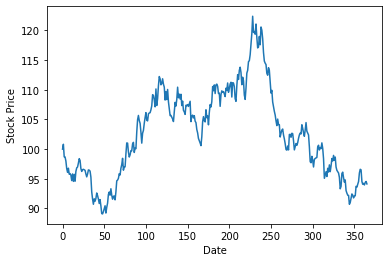

In [32]:
import matplotlib.pyplot as plt

env = AmeriOptionEnv()
s = env.reset()

sim_prices = []
sim_prices.append(s[0])
for i in range(365):
  action = 0
  s_next, reward, done, info = env.step(action)
  sim_prices.append(s_next[0])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(sim_prices)

### Section Three -- Reinforcement Learning

This section follows closely the [TF-Agent documentation](https://www.tensorflow.org/agents)

In [12]:
!pip install -q tf-agents

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [13]:
import tensorflow as tf
import numpy as np

from tf_agents.environments import  gym_wrapper           # wrap OpenAI gym
from tf_agents.environments import tf_py_environment      # gym to tf gym
from tf_agents.networks import q_network                  # Q net
from tf_agents.agents.dqn import dqn_agent                # DQN Agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer      # replay buffer
from tf_agents.trajectories import trajectory              # s->s' trajectory
from tf_agents.utils import common                       # loss function

In [14]:
# Hyper-parameters
num_iterations = 20000 # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

#### Section 3.1 Define Environment

In [15]:
train_env_gym = AmeriOptionEnv()
eval_env_gym = AmeriOptionEnv()

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env  = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#### Section 3.2 Define Q Net

In [16]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

#### Section 3.3 Define DQN Agent

In [17]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

#### Section 3.4 - Construct Experience Replay Buffer

In [18]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [19]:
# Data Collection

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [20]:
# Fetch experience

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


#### Section 3.5 - Training

In [21]:
# eval_env evaluation
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [22]:
# step 5 - training - takes a while
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 59.832584381103516
step = 400: loss = 238.35992431640625
step = 600: loss = 626.5194091796875
step = 800: loss = 1394.18701171875
step = 1000: loss = 1666.5810546875
step = 1000: Average Return = 7.270626068115234
step = 1200: loss = 1957.728759765625
step = 1400: loss = 1191.81884765625
step = 1600: loss = 1217.3583984375
step = 1800: loss = 1168.137451171875
step = 2000: loss = 1351.412109375
step = 2000: Average Return = 8.32473087310791
step = 2200: loss = 1633.104248046875
step = 2400: loss = 1531.072021484375
step = 2600: loss = 1716.333251953125
step = 2800: loss = 2605.77685546875
step = 3000: loss = 3474.59033203125
step = 3000: Average Return = 8.851873397827148
step = 3200: loss = 3067.1572265625
step = 3400: loss = 2595.95581

(0.6993183255195617, 20.0)

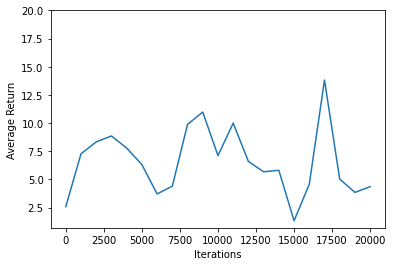

In [23]:
# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=20)

#### Section 3.6 Price American Option

In [24]:
# save policy
import os
import tempfile
from tf_agents.policies import policy_saver

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/policy/assets


In [25]:
# Monte Carlo simulation -- takes a while
# npv = compute_avg_return(eval_env, saved_policy, num_episodes=2_000)
npv = compute_avg_return(eval_env, agent.policy, num_episodes=2_000)
pricing_dict['ReinforcementAgent'] = npv
print(npv)

7.057035


In [31]:
import pandas as pd
pricing_df = pd.DataFrame.from_dict(pricing_dict, orient='index')
pricing_df.columns = ['Price']
pricing_df

,Price
BlackScholesEuropean,6.927869
BawApproximation,7.091255
BinomialTree,7.090925
ReinforcementAgent,7.057035


#### TODO

Some [variance reduction](https://en.wikipedia.org/wiki/Variance_reduction) techniques can be applied to improve simulation efficiency.

1. Use another AmeriOption gym environment to provide [Antithetic variates](https://en.wikipedia.org/wiki/Antithetic_variates)

2. In function compute_avg_return, continue the simulation path to price European option as [Control Variates](https://en.wikipedia.org/wiki/Control_variates)